In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tensorflow.keras import layers
from tensorflow import keras
import distutils
import cv2
import tensorflow as tf
from PIL import Image
from scipy import ndimage

from keras.layers import *


In [3]:
#write uour own path here
#download from ---> (https://www.kaggle.com/datasets/farhanhubble/multimnistm2nist/download?datasetVersionNumber=2)
segmented = np.load('/Downloads/segmented.npy')
combined = np.load('/Downloads/combined.npy')

In [4]:
segmented.shape

(5000, 64, 84, 11)

In [5]:
combined.shape

(5000, 64, 84)

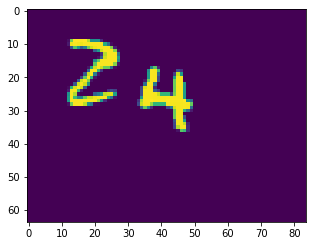

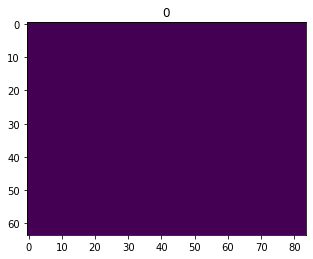

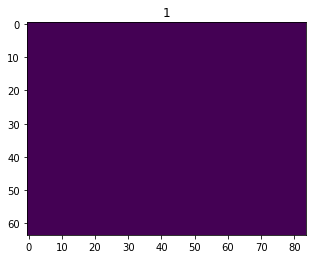

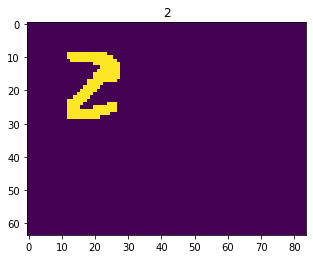

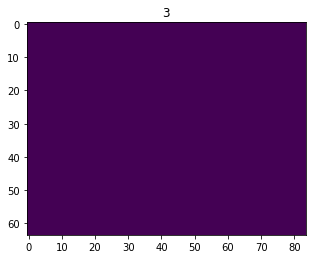

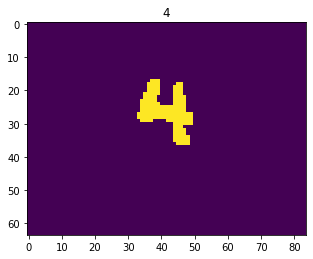

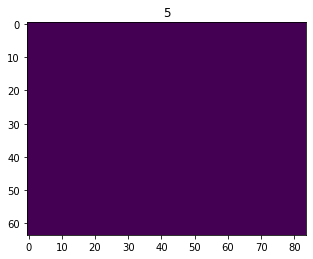

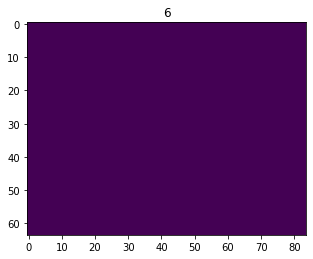

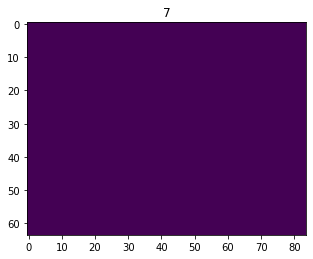

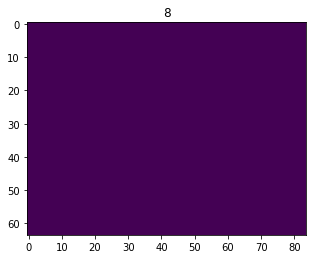

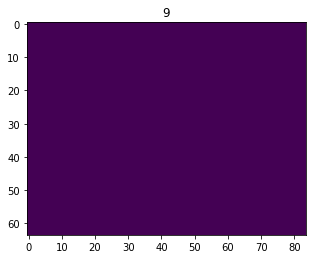

In [6]:
rand_index = np.random.randint(0,len(combined))
c,s = combined[rand_index], segmented[rand_index]
plt.figure(figsize=(5,5))
plt.imshow(c)
plt.show()

for i in range(10):
    plt.figure(figsize=(5,5))
    plt.imshow(s[:,:,i])
    plt.title(i)
    plt.show()

In [7]:
def build_model_new():
    inputs = keras.Input((64, 84, 1,))
    x = ZeroPadding2D(((0, 0), (0, 12)))(inputs)
    x = Conv2D(16, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(16, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    a1 = Activation("relu")(x)
    
    x = MaxPooling2D((2,2))(a1)
    #-->(128,128,16)
    x = Conv2D(32, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(32, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    a2 = Activation("relu")(x)
    
    x = MaxPooling2D((2,2))(a2)
    #-->(64,64,32)
    x = Conv2D(48, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(48, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    a3 = Activation("relu")(x)
    
    x = MaxPooling2D((2,2))(a3)
    #-->(32,32,48)
    x = Conv2D(64, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(64, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    a4 = Activation("relu")(x)
    
    x = MaxPooling2D((2,2))(a4)

    #Middle
    x = Conv2D(64, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(64, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    #Middle
    x = UpSampling2D((2,2))(x)
    x = Concatenate()([x, a4])
    
    x = Conv2D(64, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(64, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D((2,2))(x)
    x = Concatenate()([x, a3])
    
    x = Conv2D(48, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(48, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D((2,2))(x)
    x = Concatenate()([x, a2])
    
    x = Conv2D(32, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(32, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = UpSampling2D((2,2))(x)
    x = Concatenate()([x, a1])
    
    x = Conv2D(16, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(16, (3,3), padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(11,(1,1), padding = "same")(x)
    x = keras.layers.Cropping2D(((0, 0), (0, 12)))(x)
    x = Activation("softmax")(x)
    return keras.Model(inputs, x)

In [8]:
model_16 = build_model_new()
model_16.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_16, show_shapes=True, show_layer_names=True)

In [9]:
# Debugging: print shapes of original arrays
print(f"Shape of combined: {combined.shape}")
print(f"Shape of segmented: {segmented.shape}")

# Normalize the combined images
combined = combined / 255.0



Shape of combined: (5000, 64, 84)
Shape of segmented: (5000, 64, 84, 11)


In [10]:
combined = np.expand_dims(combined, axis=-1)

# Debugging: print shape after expanding dimensions
print(f"Shape of combined after expanding dimensions: {combined.shape}")

# Ensure the segmented has the correct shape (5000, 64, 84, 11)
if segmented.shape[-1] == 11:
    segmented = np.argmax(segmented, axis=-1)
segmented = keras.utils.to_categorical(segmented, num_classes=11)

# Debugging: print shape after ensuring correct shape
print(f"Shape of segmented after ensuring correct shape: {segmented.shape}")

# Split the data into training and validation sets
train_size = int(0.8 * len(combined))
x_train, x_val = combined[:train_size], combined[train_size:]
y_train, y_val = segmented[:train_size], segmented[train_size:]

Shape of combined after expanding dimensions: (5000, 64, 84, 1)
Shape of segmented after ensuring correct shape: (5000, 64, 84, 11)


In [11]:

# Build the model
model_16 = build_model_new()
# Compile the model
model_16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [23]:
# Train the model
model_16.fit(x_train, y_train, batch_size=25, epochs=50)

Epoch 1/50
160/160 [==============================] - 5s 28ms/step - loss: 0.0051 - accuracy: 0.9990
Epoch 2/50
160/160 [==============================] - 4s 28ms/step - loss: 0.0053 - accuracy: 0.9988
Epoch 3/50
160/160 [==============================] - 5s 28ms/step - loss: 0.0042 - accuracy: 0.9991
Epoch 4/50
160/160 [==============================] - 5s 28ms/step - loss: 0.0036 - accuracy: 0.9993
Epoch 5/50
160/160 [==============================] - 5s 28ms/step - loss: 0.0045 - accuracy: 0.9990
Epoch 6/50
160/160 [==============================] - 5s 29ms/step - loss: 0.0041 - accuracy: 0.9991
Epoch 7/50
160/160 [==============================] - 5s 29ms/step - loss: 0.0030 - accuracy: 0.9993
Epoch 8/50
160/160 [==============================] - 5s 29ms/step - loss: 0.0026 - accuracy: 0.9994
Epoch 9/50
160/160 [==============================] - 5s 29ms/step - loss: 0.0035 - accuracy: 0.9992
Epoch 10/50
160/160 [==============================] - 5s 29ms/step - loss: 0.0018 - accura

In [25]:
from sklearn.model_selection import KFold

# Define the number of folds for cross-validation
n_splits = 5

# Initialize lists to store validation losses and accuracies for each fold
val_losses = []
val_accuracies = []

# Perform cross-validation
kf = KFold(n_splits=n_splits)
for train_index, val_index in kf.split(combined):
    # Split the data into training and validation sets
    x_train, x_val = combined[train_index], combined[val_index]
    y_train, y_val = segmented[train_index], segmented[val_index]
    
    # Train the model on this fold
    history = model_16.fit(x_train, y_train, epochs=3, batch_size=25, verbose=0)
    
    # Evaluate the model on the validation set for this fold
    val_loss, val_accuracy = model_16.evaluate(x_val, y_val, verbose=0)
    
    # Append the validation loss and accuracy to the lists
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

# Calculate the mean and standard deviation of validation loss and accuracy across folds
mean_val_loss = np.mean(val_losses)
mean_val_accuracy = np.mean(val_accuracies)
std_val_loss = np.std(val_losses)
std_val_accuracy = np.std(val_accuracies)

# Print the results
print(f'Cross-Validation Results:')
print(f'Mean Validation Loss: {mean_val_loss} ± {std_val_loss}')
print(f'Mean Validation Accuracy: {mean_val_accuracy} ± {std_val_accuracy}')


Cross-Validation Results:
Mean Validation Loss: 75.35909743309021 ± 81.14743273941733
Mean Validation Accuracy: 0.944754683971405 ± 0.002746120323580212


Validation Accuracy is around 94%

Now applying the Architecture but using Multiple Gradient Descent Algorithm – Upper Bound for calculating loss

In [14]:
# Normalize images
combined = combined / 255.0

# Convert masks to categorical
segmented = segmented.astype(np.uint8)
segmented = np.argmax(segmented, axis=-1)
segmented = tf.keras.utils.to_categorical(segmented, num_classes=11)

print("Combined shape after normalization:", combined.shape)
print("Segmented shape after conversion:", segmented.shape)

# Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

combined_train, combined_val, segmented_train, segmented_val = train_test_split(combined, segmented, test_size=0.2, random_state=42)

print("Training set shape:", combined_train.shape, segmented_train.shape)
print("Validation set shape:", combined_val.shape, segmented_val.shape)

Combined shape after normalization: (5000, 64, 84, 1)
Segmented shape after conversion: (5000, 64, 84, 11)
Training set shape: (4000, 64, 84, 1) (4000, 64, 84, 11)
Validation set shape: (1000, 64, 84, 1) (1000, 64, 84, 11)


In [15]:
def build_model_new():
    inputs = keras.Input((64, 84, 1))
    x = ZeroPadding2D(((0, 0), (0, 12)))(inputs)
    
    # Encoder
    x = Conv2D(16, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(16, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    a1 = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(a1)
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    a2 = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(a2)
    x = Conv2D(48, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(48, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    a3 = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(a3)
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    a4 = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(a4)

    # Middle
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, a4])
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(64, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, a3])
    x = Conv2D(48, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(48, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, a2])
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(32, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, a1])
    x = Conv2D(16, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(16, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(11, (1, 1), padding="same")(x)
    x = keras.layers.Cropping2D(((0, 0), (0, 12)))(x)
    x = Activation("softmax")(x)

    return keras.Model(inputs, x)

model = build_model_new()


In [16]:
#Implementing Multiple Gradient Descent Algorithm – Upper Bound
def mgda_ub_loss(y_true, y_pred, model):
    segmented_losses = [keras.losses.categorical_crossentropy(y_true[..., i], y_pred[..., i]) for i in range(11)]
    
    # Calculate gradients of each task-specific loss w.r.t. the shared representation
    task_gradients = []
    with tf.GradientTape(persistent=True) as tape:
        for loss in segmented_losses:
            gradients = tape.gradient(loss, model.trainable_variables)
            task_gradients.append(gradients)
    
    # Compute the combined gradient norm
    mgda_ub = sum([tf.reduce_sum(tf.square(g)) for gradients in task_gradients for g in gradients if g is not None])
    
    # Clean up the tape
    del tape
    
    return tf.cast(mgda_ub, dtype=tf.float32)  # Ensure mgda_ub is returned as a tensor

In [18]:
# Create tf.data datasets
batch_size = 25
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)


In [26]:
# Create tf.data datasets
batch_size = 25
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
# Optimizer
optimizer = tf.keras.optimizers.Adam()

# Training loop
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)
            loss_value = keras.losses.categorical_crossentropy(y_batch_train, logits)
            mgda_ub_value = mgda_ub_loss(y_batch_train, logits, model)
            total_loss = tf.reduce_mean(loss_value) + mgda_ub_value
            
        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        if step % 100 == 0:
            print(f"Step {step}: loss = {tf.reduce_mean(loss_value).numpy()}, MGDA-UB = {mgda_ub_value.numpy()}")

    # Validation step
    val_loss = 0
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val, training=False)
        val_loss += tf.reduce_mean(keras.losses.categorical_crossentropy(y_batch_val, val_logits)).numpy()
    val_loss /= len(val_dataset)
    print(f"Validation loss: {val_loss}")


Epoch 1/100
Step 0: loss = 0.06611475348472595, MGDA-UB = 0.0
Step 100: loss = 0.011797886341810226, MGDA-UB = 0.0
Validation loss: 2.9383245527744295
Epoch 2/100
Step 0: loss = 0.005191333591938019, MGDA-UB = 0.0
Step 100: loss = 0.0021756875794380903, MGDA-UB = 0.0
Validation loss: 15.263971877098083
Epoch 3/100
Step 0: loss = 0.002165037440136075, MGDA-UB = 0.0
Step 100: loss = 0.002859157044440508, MGDA-UB = 0.0
Validation loss: 71.3902545928955
Epoch 4/100
Step 0: loss = 0.003171565243974328, MGDA-UB = 0.0
Step 100: loss = 0.0010547233978286386, MGDA-UB = 0.0
Validation loss: 89.84753875732422
Epoch 5/100
Step 0: loss = 0.0014160634018480778, MGDA-UB = 0.0
Step 100: loss = 0.003760460764169693, MGDA-UB = 0.0
Validation loss: 8.977874517440796
Epoch 6/100
Step 0: loss = 0.0016741864383220673, MGDA-UB = 0.0
Step 100: loss = 0.0044379644095897675, MGDA-UB = 0.0
Validation loss: 46.49954795837402
Epoch 7/100
Step 0: loss = 0.0013235281221568584, MGDA-UB = 0.0
Step 100: loss = 0.001358

In [27]:
def compute_accuracy(y_true, y_pred):
    # Convert one-hot encoded predictions to class labels
    y_pred_labels = np.argmax(y_pred, axis=-1)
    
    # Convert one-hot encoded true labels to class labels
    y_true_labels = np.argmax(y_true, axis=-1)
    
    # Compute pixel-wise accuracy
    correct_pixels = np.sum(y_pred_labels == y_true_labels)
    total_pixels = np.prod(y_pred_labels.shape)
    accuracy = correct_pixels / total_pixels
    
    return accuracy

# Validation step
accuracies = []
for x_batch_val, y_batch_val in val_dataset:
    val_logits = model(x_batch_val, training=False)
    val_accuracy = compute_accuracy(y_batch_val, val_logits)
    accuracies.append(val_accuracy)

average_accuracy = np.mean(accuracies)
print(f"Average validation accuracy: {average_accuracy}")



Average validation accuracy: 0.9993831845238095


Accuracy using MGDA-UB 99.9 %